In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
#import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import data_block, basic_train, basic_data
import fastai

In [2]:
from my_nn_modules import AE_big

In [3]:
fastai.torch_core.defaults.device = 'cuda'

In [4]:
# Load data
train = pd.read_pickle('processed_data/train.pkl')
test = pd.read_pickle('processed_data/test.pkl')
n_features = len(train.loc[0])

train.head(10)

,pT,eta,phi,E
1367643,300.752869,0.118391,-1.460827,303.719818
1739612,79.819145,4.535507,-1.185196,3722.832764
546066,220.472305,1.314261,-0.943992,440.195190
213212,74.533775,0.010658,-0.424795,74.770332
150544,220.668121,2.432910,-2.308348,1266.681030
574837,159.841782,0.731125,-1.150598,207.133514
1171687,306.125305,0.702473,0.437615,385.713013
1608254,189.011673,-1.387443,0.490634,403.126709
1618830,194.996719,-1.022815,-1.560437,306.534515
637947,186.887146,-0.621282,-0.465523,226.002701


In [5]:
# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
# Is this the right way to normalize? (only using train mean and std to normalize both train and test)
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

In [6]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [30]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs=512)

In [31]:
db = basic_data.DataBunch(train_dl, valid_dl)

In [32]:
db

DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7f9159d1c290>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7f91a37eaa10>;

Test: None

In [42]:
class AE_big_2D_v1(nn.Module):
    def __init__(self, n_features=4):
        super(AE_big_2D_v1, self).__init__()
        self.en1 = nn.Linear(n_features, 8)
        self.en2 = nn.Linear(8, 6)
        self.en3 = nn.Linear(6, 4)
        self.en4 = nn.Linear(4, 2)
        self.de1 = nn.Linear(2, 4)
        self.de2 = nn.Linear(4, 6)
        self.de3 = nn.Linear(6, 8)
        self.de4 = nn.Linear(8, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)
    

class AE_big_2D_v2(nn.Module):
    def __init__(self, n_features=4):
        super(AE_big_2D_v2, self).__init__()
        self.en1 = nn.Linear(n_features, 8)
        self.en2 = nn.Linear(8, 6)
        self.en3 = nn.Linear(6, 4)
        self.en4 = nn.Linear(4, 3)
        self.en5 = nn.Linear(3, 2)
        self.de1 = nn.Linear(2, 3)
        self.de2 = nn.Linear(3, 4)
        self.de3 = nn.Linear(4, 6)
        self.de4 = nn.Linear(6, 8)
        self.de5 = nn.Linear(8, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en5(self.tanh(self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))))

    def decode(self, x):
        return self.de5(self.tanh(self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

In [43]:
model = AE_big_2D_v2()

In [44]:
#def my_loss_func(input, target):
#    np.power(target - input, 2).mean()
loss_func = nn.MSELoss()
#loss_func = my_loss_func
#loss_func = model.ae_loss
#learn = basic_train.Learner(data=db, model=model, loss_func=loss_func)

In [45]:
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func)

In [46]:
from fastai import train
train.lr_find(learn, end_lr=.3e1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


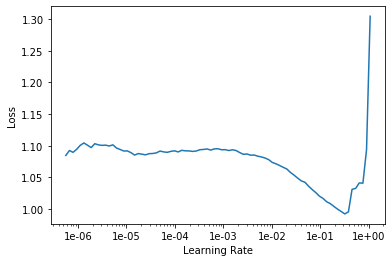

In [47]:
learn.recorder.plot()

In [48]:
learn.data.train_ds.tensors[0][0]

tensor([ 0.6136,  0.0878, -0.8069, -0.5152])

In [49]:
lr = 1e-2
learn.fit_one_cycle(4, max_lr=lr)

epoch,train_loss,valid_loss,time
0,0.194664,0.179019,00:34
1,0.099635,0.095971,00:34
2,0.082996,0.084345,00:34
3,0.080651,0.080154,00:34


In [51]:
lr = 1e-2
learn.fit_one_cycle(4, max_lr=lr)

epoch,train_loss,valid_loss,time
0,0.107780,0.075857,00:34
1,0.075773,0.073835,00:34
2,0.068084,0.069066,00:34
3,0.066148,0.066593,00:34


In [ ]:
lr = 1e-3
learn.fit_one_cycle(20, max_lr=lr)

epoch,train_loss,valid_loss,time
0,0.067081,0.066544,00:34
1,0.079650,0.066457,00:34
2,0.066255,0.066459,00:34
3,0.066314,0.066316,00:34
4,0.130423,0.066093,00:34
5,0.066256,0.065869,00:34
6,0.065952,0.065906,00:34
7,0.066381,0.065567,00:34
8,0.065503,0.065537,00:34
9,0.065162,0.065195,00:34


In [15]:
learn.fit_one_cycle(15, max_lr=1e-4)

epoch,train_loss,valid_loss,time
0,0.000241,0.000294,01:22
1,0.000405,0.000297,01:22
2,0.000237,0.000291,01:23
3,0.000367,0.000310,01:21
4,0.000245,0.000293,01:22
5,0.000503,0.000284,01:22
6,0.000430,0.000276,01:21
7,0.000316,0.000275,01:22
8,0.000172,0.000271,01:22
9,0.000265,0.000269,01:21


In [16]:
inp = learn.data.train_ds.tensors[0][0]
outp = model(learn.data.train_ds.tensors[0][0])
print('Input:', inp)
print('Output:', outp)

Input: tensor([ 0.6136,  0.0878, -0.8069, -0.5152])
Output: tensor([ 0.6154,  0.0850, -0.8192, -0.5163], grad_fn=<AddBackward0>)


In [17]:
learn.data.train_ds.tensors[0][0]

tensor([ 0.6136,  0.0878, -0.8069, -0.5152])